# <b><font size=7 color='orange'> Computer Assignment 4 - Task 1 </font></b>

<b><font color="orange" size="6">Collaborators:</font></b><br>
<font color="orange" size="5">
  <i>Golboo Rashidi - 810100148<br>
     Mehrad Liviyan - 810101501<br>
     Pooria Mahdian - 810101530
  </i>
</font>

# Import Libaraies and  Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.optim.lr_scheduler import OneCycleLR
from collections import defaultdict


In [ ]:
matches = pd.read_csv("/content/drive/MyDrive/DataScience-S04/CA4/task1/matches.csv")

 # Exploratory Data Analysis

In [ ]:
matches.head()

,Unnamed: 0,home_team,home_goals,away_goals,away_team,wcm,dif_inter_match,dif_inter_match_won,dif_inter_match_lost,dif_inter_match_tie,dif_inter_goals_sco,dif_inter_goals_con,dif_wc_match,dif_wc_match_won,dif_wc_match_lost,dif_wc_match_tied,dif_wc_goals_sco,dif_wc_goals_con,status
0,0,Spain,1,0,Czechoslovakia,0,488.0,315.0,60.0,113.0,1061.0,346.0,33.0,19.0,4.0,10.0,55.0,27.0,1
1,1,Portugal,1,0,Czechoslovakia,0,438.0,222.0,113.0,103.0,748.0,466.0,0.0,3.0,-4.0,1.0,5.0,-10.0,1
2,2,Northern Ireland,7,0,Wales,0,-373.0,-164.0,-136.0,-73.0,-544.0,-409.0,8.0,2.0,4.0,2.0,9.0,19.0,1
3,3,Italy,4,2,Switzerland,0,-438.0,-120.0,-259.0,-59.0,-595.0,-936.0,46.0,33.0,0.0,13.0,78.0,13.0,1
4,4,Portugal,2,0,France,0,-191.0,-101.0,-61.0,-29.0,-388.0,-353.0,-36.0,-20.0,-9.0,-7.0,-71.0,-42.0,1


In [ ]:
print("Dataset Shape:", matches.shape)
print("\nData Types:\n", matches.dtypes)
print("\nMissing Values:\n", matches.isnull().sum())

Dataset Shape: (17812, 19)

Data Types:
 Unnamed: 0                int64
home_team                object
home_goals                int64
away_goals                int64
away_team                object
wcm                       int64
dif_inter_match         float64
dif_inter_match_won     float64
dif_inter_match_lost    float64
dif_inter_match_tie     float64
dif_inter_goals_sco     float64
dif_inter_goals_con     float64
dif_wc_match            float64
dif_wc_match_won        float64
dif_wc_match_lost       float64
dif_wc_match_tied       float64
dif_wc_goals_sco        float64
dif_wc_goals_con        float64
status                    int64
dtype: object

Missing Values:
 Unnamed: 0              0
home_team               0
home_goals              0
away_goals              0
away_team               0
wcm                     0
dif_inter_match         0
dif_inter_match_won     0
dif_inter_match_lost    0
dif_inter_match_tie     0
dif_inter_goals_sco     0
dif_inter_goals_con     0
dif_wc_

No need to handle missing values!

In [ ]:
palette = {
    '1': "springgreen",
    '2': "khaki",
    '3': "lightcoral"
}

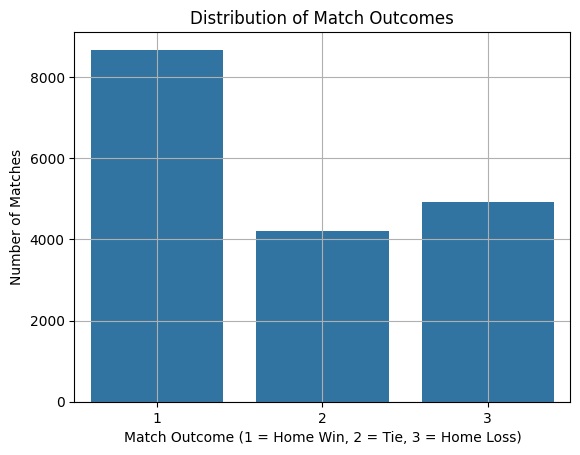

In [ ]:
#sns.countplot(x='status', data=matches, palette=palette)
sns.countplot(x='status', data=matches)
plt.title("Distribution of Match Outcomes")
plt.xlabel("Match Outcome (1 = Home Win, 2 = Tie, 3 = Home Loss)")
plt.ylabel("Number of Matches")
plt.grid(True)
plt.show()

In [ ]:
print(matches['status'].value_counts(normalize=True) * 100)

status
1    48.697507
3    27.661127
2    23.641365
Name: proportion, dtype: float64


In [ ]:
diff_features = [col for col in matches.columns if 'dif' in col]
print("Difference Features:", diff_features)

Difference Features: ['dif_inter_match', 'dif_inter_match_won', 'dif_inter_match_lost', 'dif_inter_match_tie', 'dif_inter_goals_sco', 'dif_inter_goals_con', 'dif_wc_match', 'dif_wc_match_won', 'dif_wc_match_lost', 'dif_wc_match_tied', 'dif_wc_goals_sco', 'dif_wc_goals_con']


In [ ]:
for feature in diff_features:
    q_low = matches[feature].quantile(0.01)
    q_high = matches[feature].quantile(0.99)
    matches[feature] = matches[feature].clip(lower=q_low, upper=q_high)

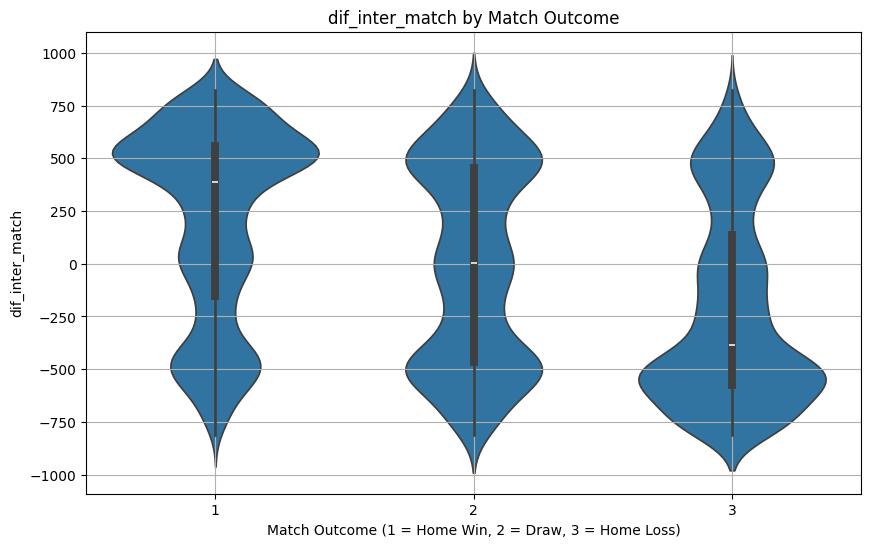

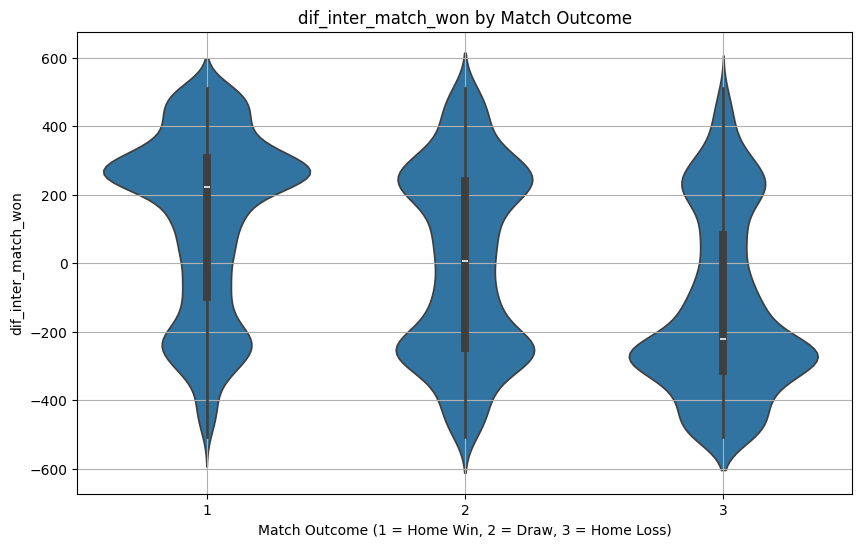

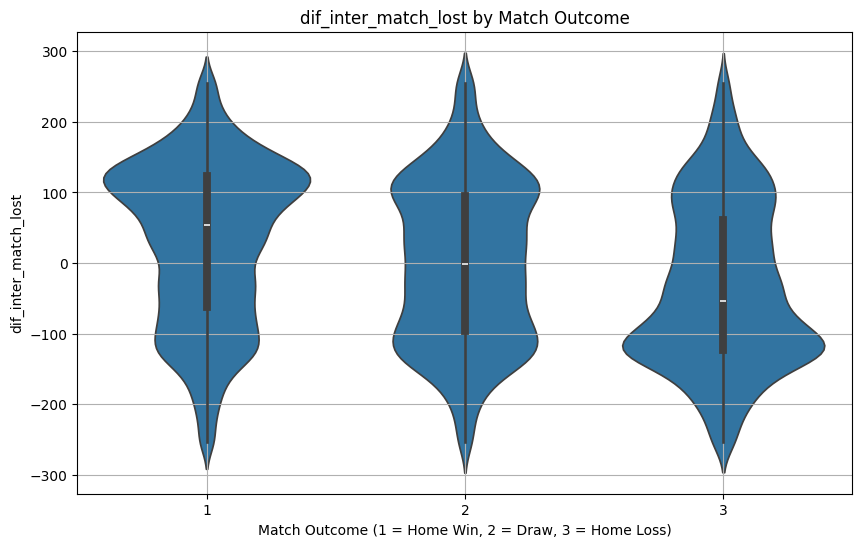

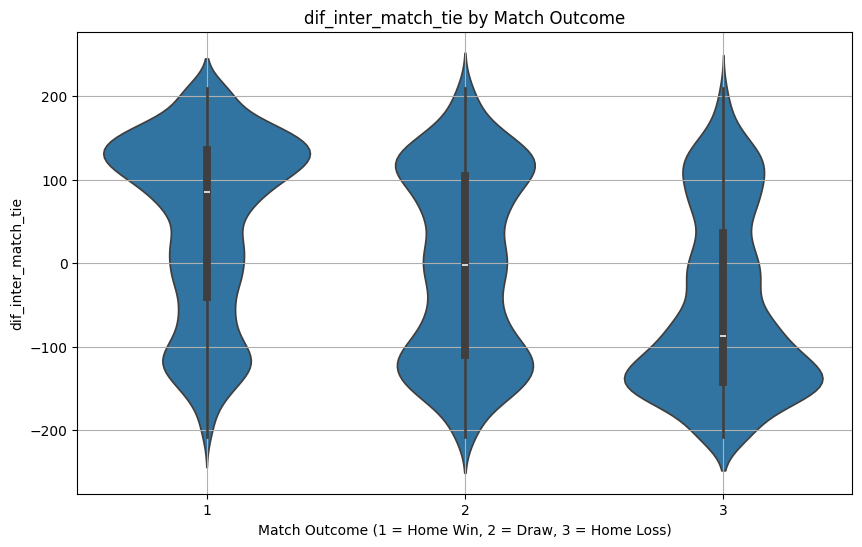

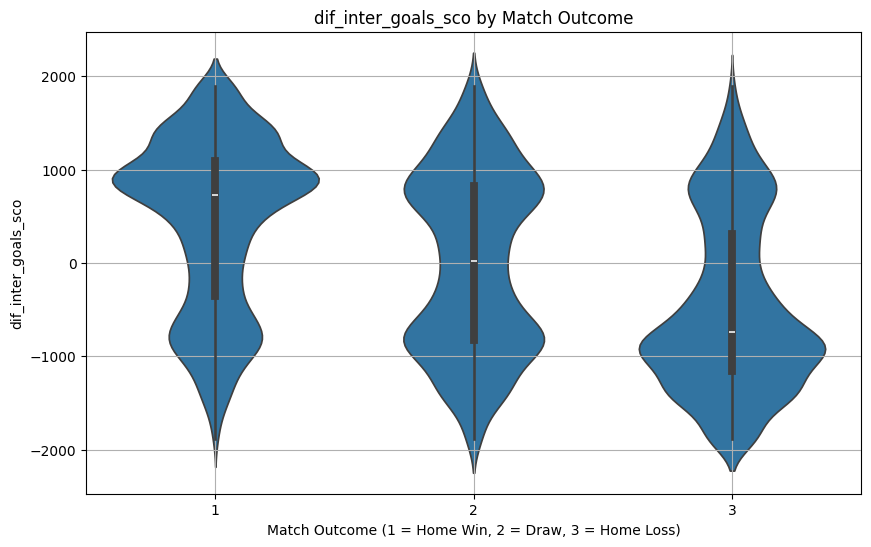

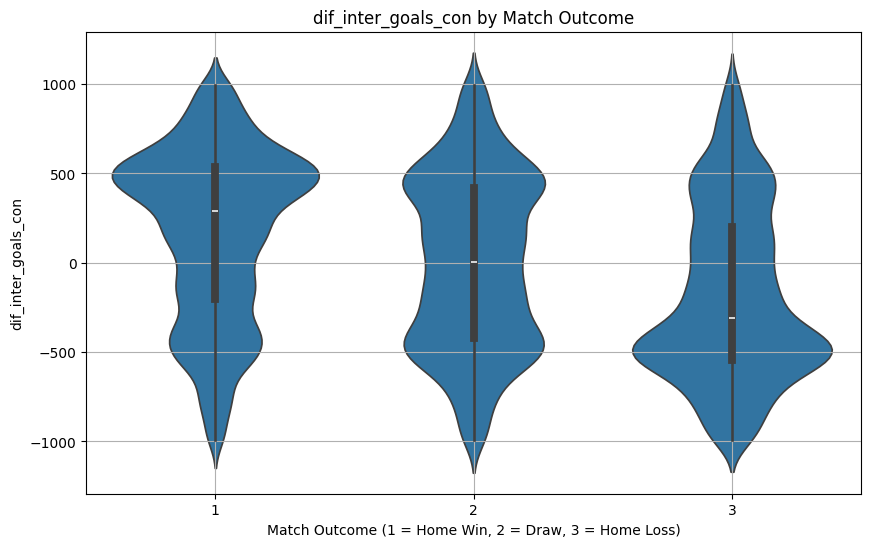

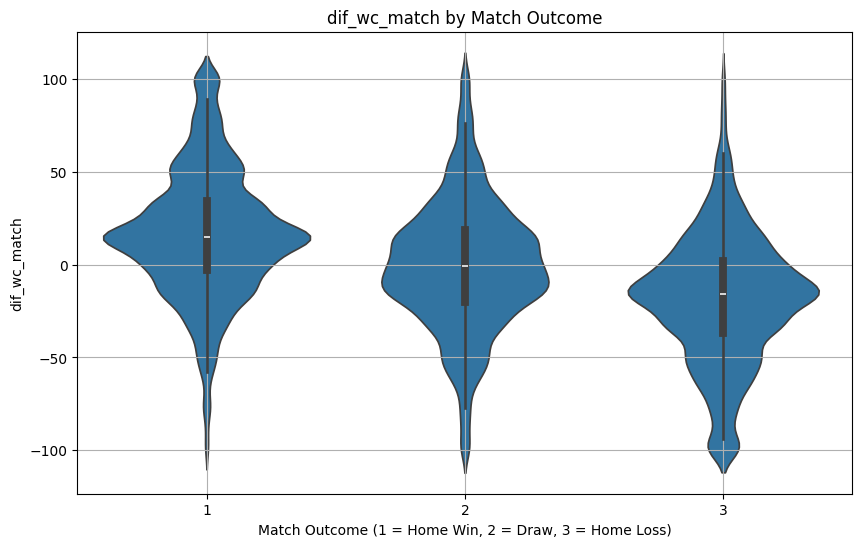

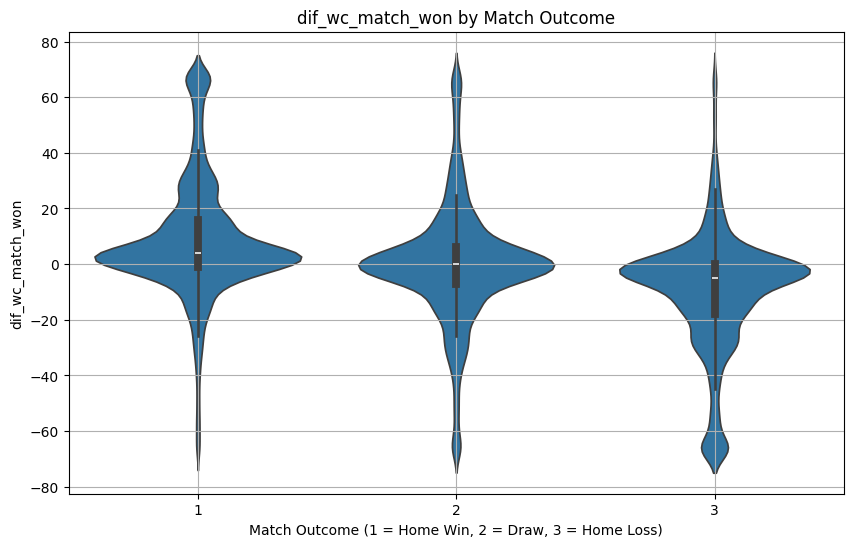

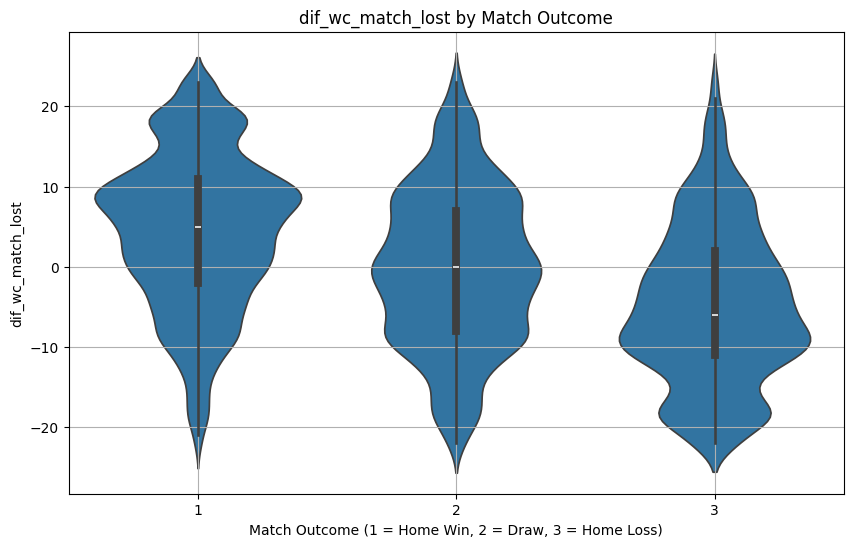

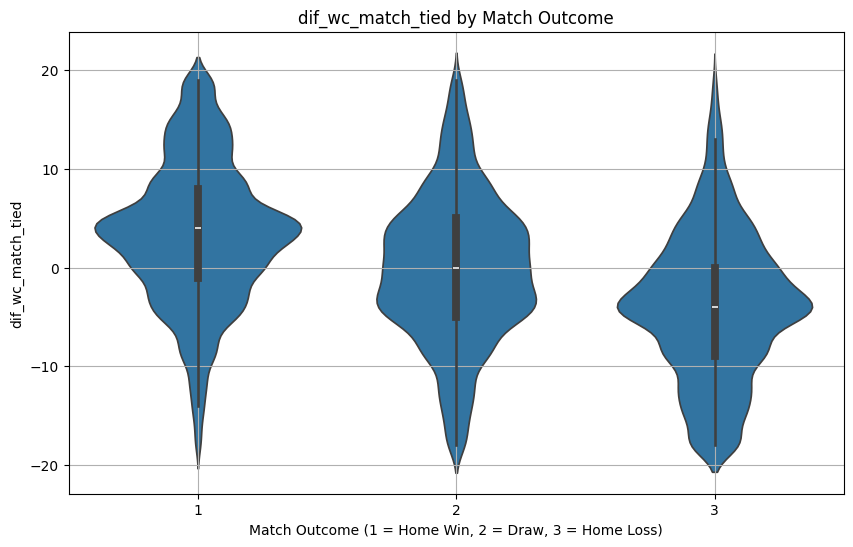

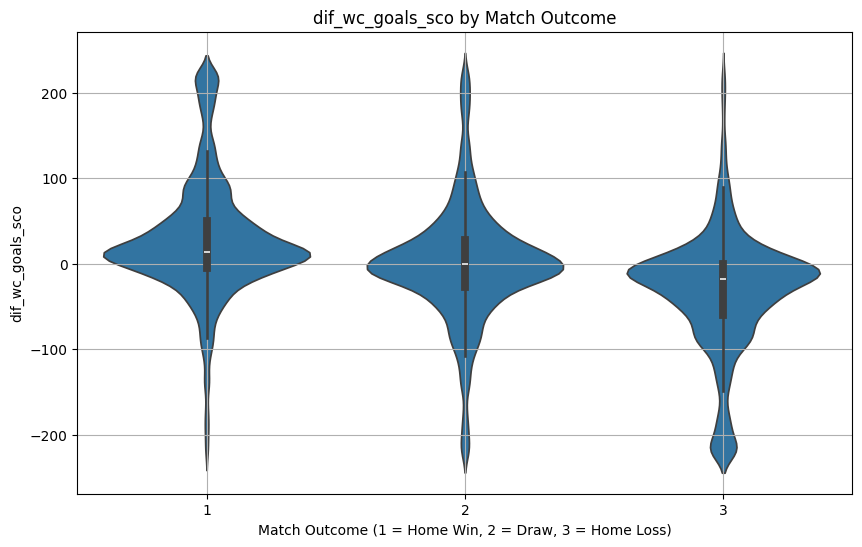

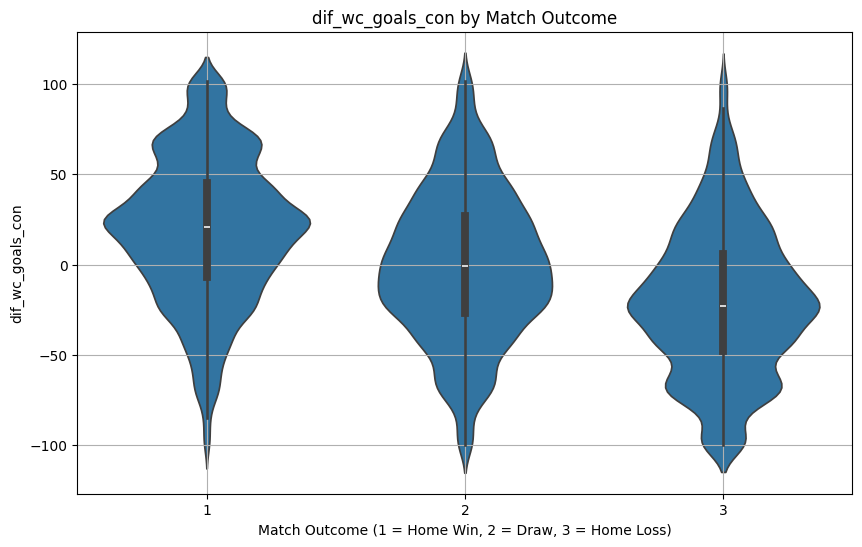

In [ ]:
for feature in diff_features:
    plt.figure(figsize=(10, 6))
    #sns.violinplot(data=matches, x='status', y=feature, palette=palette)
    sns.violinplot(data=matches, x='status', y=feature)
    plt.title(f'{feature} by Match Outcome')
    plt.xlabel('Match Outcome (1 = Home Win, 2 = Draw, 3 = Home Loss)')
    plt.ylabel(feature)
    plt.grid(True)
    plt.show()

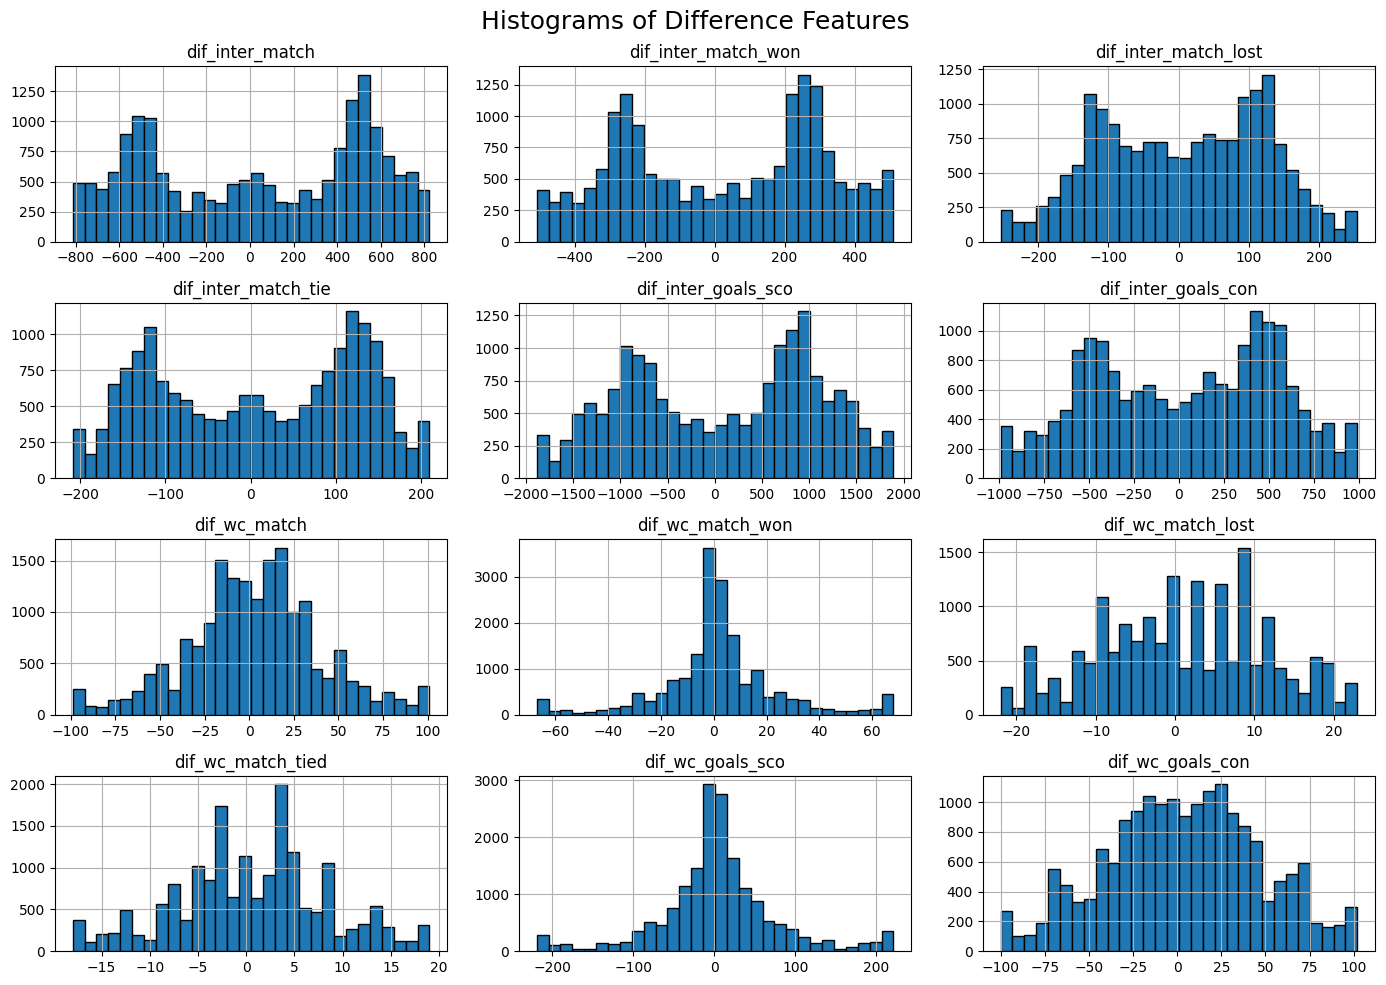

In [ ]:
matches[diff_features].hist(bins=30, figsize=(14, 10), edgecolor='black')
plt.suptitle('Histograms of Difference Features', fontsize=18)
plt.tight_layout()
plt.show()

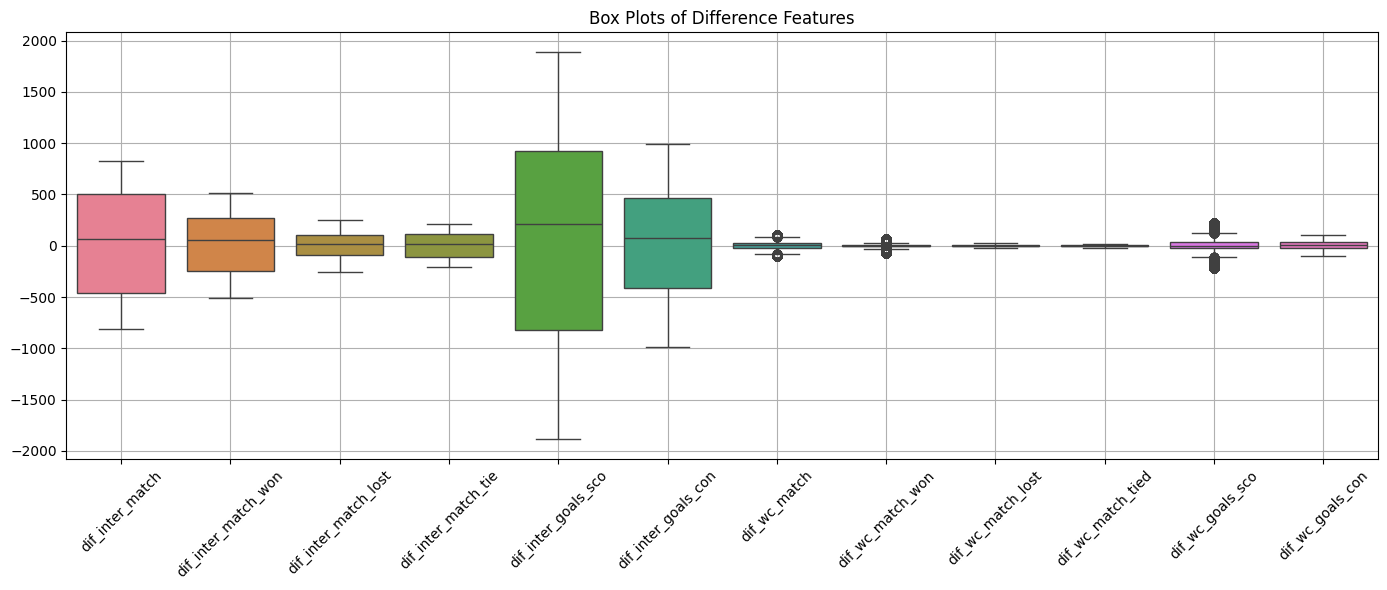

In [ ]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=matches[diff_features])
plt.title('Box Plots of Difference Features')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

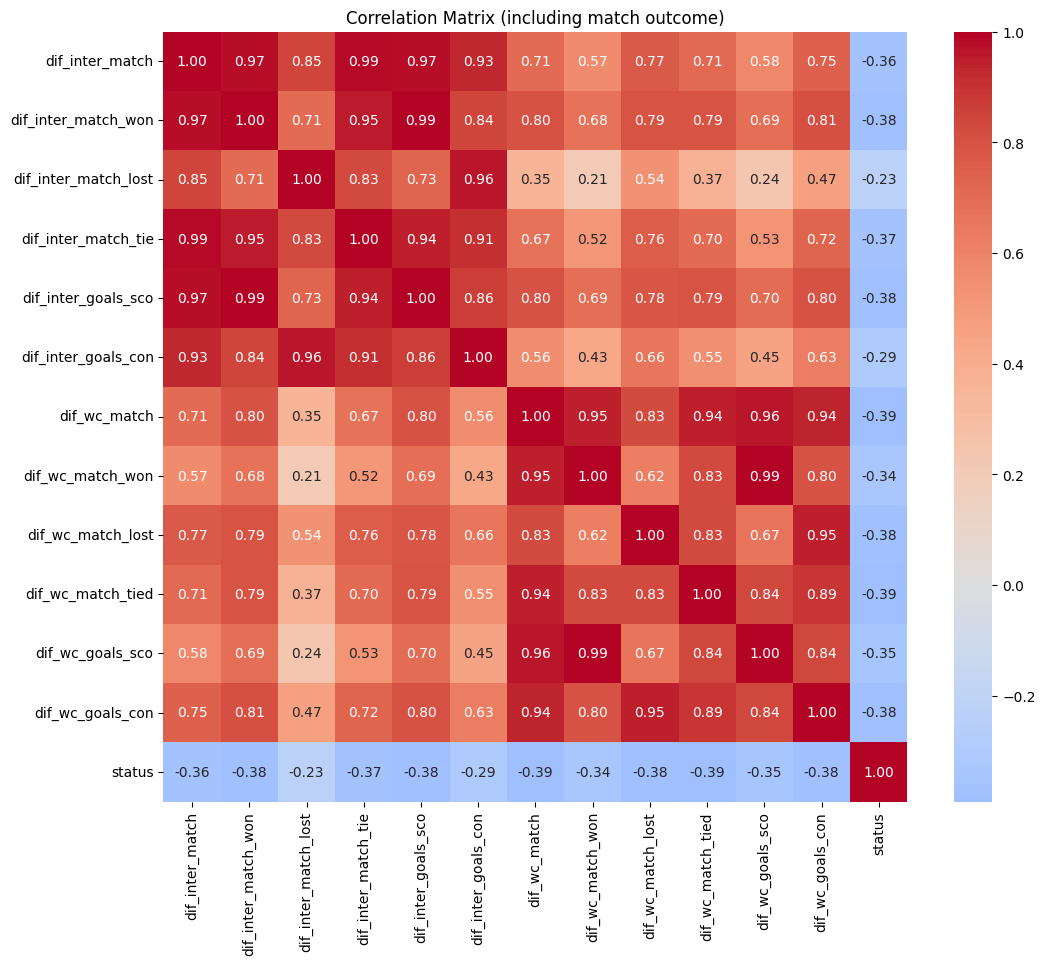

In [ ]:
plt.figure(figsize=(12, 10))
corr_matrix = matches[diff_features + ['status']].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix (including match outcome)')
plt.show()

Analyze Team Performance (Home vs. Away)

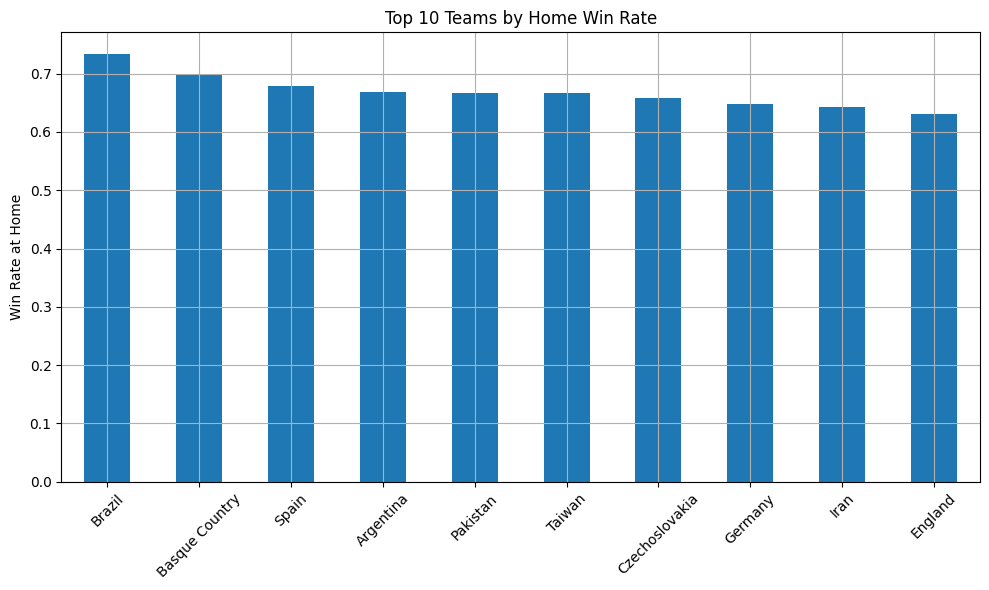

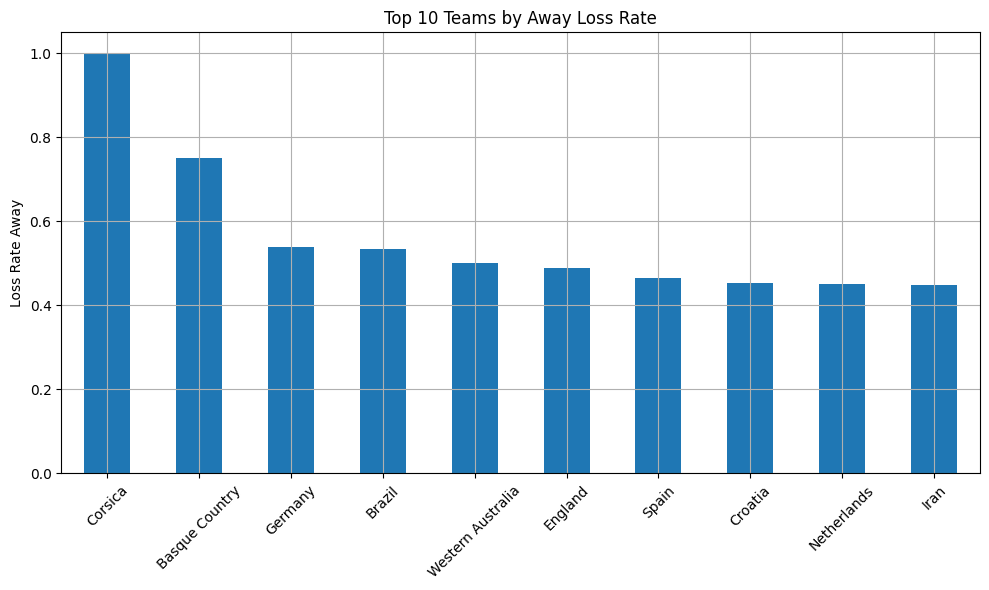

In [ ]:
home_win_rate = matches[matches['status'] == 1].groupby('home_team').size() / matches.groupby('home_team').size()
away_loss_rate = matches[matches['status'] == 3].groupby('away_team').size() / matches.groupby('away_team').size()

team_perf = pd.DataFrame({'home_win_rate': home_win_rate,'away_loss_rate': away_loss_rate}).fillna(0).sort_values(by='home_win_rate', ascending=False)

plt.figure(figsize=(10, 6))
#team_perf['home_win_rate'].head(10).plot(kind='bar', color='#90ee90')
team_perf['home_win_rate'].head(10).plot(kind='bar')
plt.title('Top 10 Teams by Home Win Rate')
plt.ylabel('Win Rate at Home')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
#team_perf['away_loss_rate'].sort_values(ascending=False).head(10).plot(kind='bar', color='#ffcccb')
team_perf['away_loss_rate'].sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 Teams by Away Loss Rate')
plt.ylabel('Loss Rate Away')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Compare Same Team in Home vs. Away Contexts

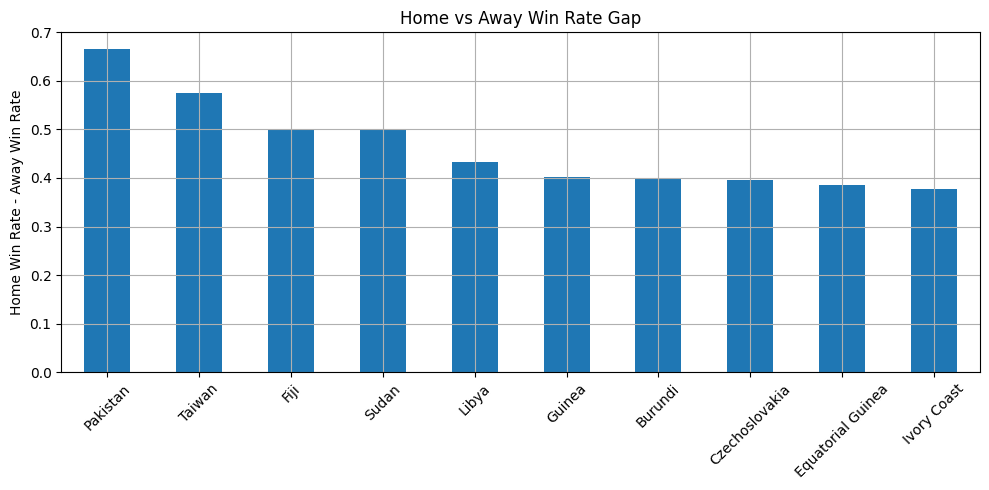

In [ ]:
team_win_home = matches[matches['status'] == 1].groupby('home_team').size()
team_win_away = matches[matches['status'] == 3].groupby('away_team').size()

team_total_home = matches.groupby('home_team').size()
team_total_away = matches.groupby('away_team').size()

home_win_rate = (team_win_home / team_total_home).fillna(0)
away_win_rate = (team_win_away / team_total_away).fillna(0)

performance_gap = (home_win_rate - away_win_rate).sort_values(ascending=False)

# Visualize largest gaps
performance_gap.head(10).plot(kind='bar', figsize=(10, 5), title='Home vs Away Win Rate Gap')
plt.ylabel('Home Win Rate - Away Win Rate')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Heatmap of Team Performance Across Locations

 distribution of match outcomes between World Cup and Qualifier games

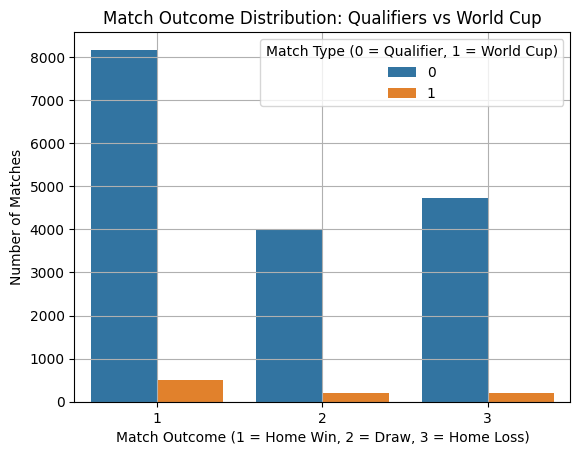

In [ ]:
sns.countplot(data=matches, x='status', hue='wcm')
plt.title('Match Outcome Distribution: Qualifiers vs World Cup')
plt.xlabel('Match Outcome (1 = Home Win, 2 = Draw, 3 = Home Loss)')
plt.ylabel('Number of Matches')
plt.legend(title='Match Type (0 = Qualifier, 1 = World Cup)')
plt.grid(True)
plt.show()

In [ ]:
leakage_cols = ['home_goals', 'away_goals', 'goal_diff','home_team', 'away_team']
matches_clean = matches.drop(columns=[col for col in leakage_cols if col in matches.columns])

We screened all numeric columns in matches_clean to understand their central tendency and dispersion. This step tells us whether rescaling, outlier handling, or additional transformations are required before we feed the data to a neural-network classifier.

In [ ]:
numerical_features = matches_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features = [col for col in numerical_features if col not in ['Unnamed: 0', 'status', 'wcm']]

matches_clean[numerical_features].describe().T[['min', 'max', 'mean', 'std']]

,min,max,mean,std
dif_inter_match,-813.00,823.00,39.255390,492.992368
dif_inter_match_won,-509.00,511.00,24.742982,284.473576
dif_inter_match_lost,-253.89,255.00,6.272383,117.762748
dif_inter_match_tie,-209.00,210.00,8.181844,117.447860
dif_inter_goals_sco,-1887.00,1891.78,85.084697,1002.606335
dif_inter_goals_con,-991.89,993.00,33.359572,504.633693
dif_wc_match,-99.00,101.00,2.790927,37.795213
dif_wc_match_won,-67.00,68.00,1.455592,22.937079
dif_wc_match_lost,-22.00,23.00,0.773916,10.476569
dif_wc_match_tied,-18.00,19.00,0.556984,7.913735


Several International metrics `(dif_inter_*)` range from roughly **–1900** to **+1900**, while World-Cup-level metrics `(dif_wc_*)` vary roughly **±100**.<br>
Given these disparities, feeding the raw numbers into our model would bias the model toward features with the biggest absolute scales.


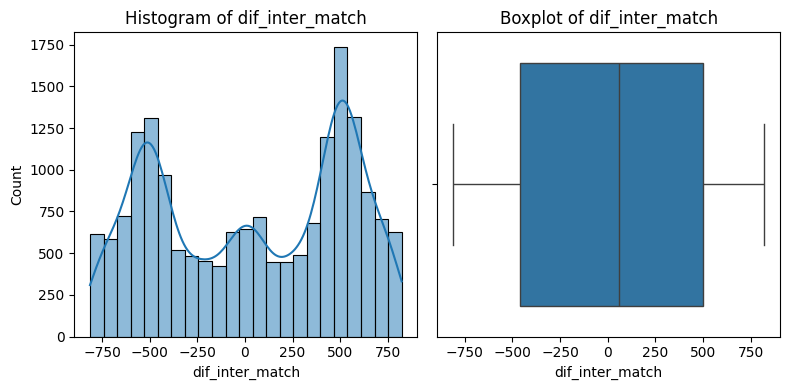

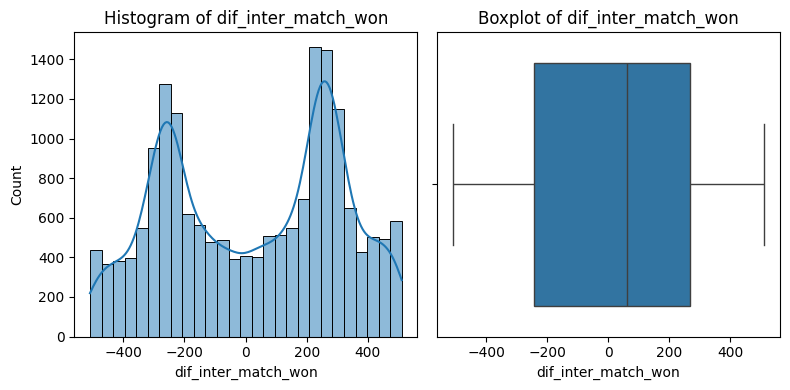

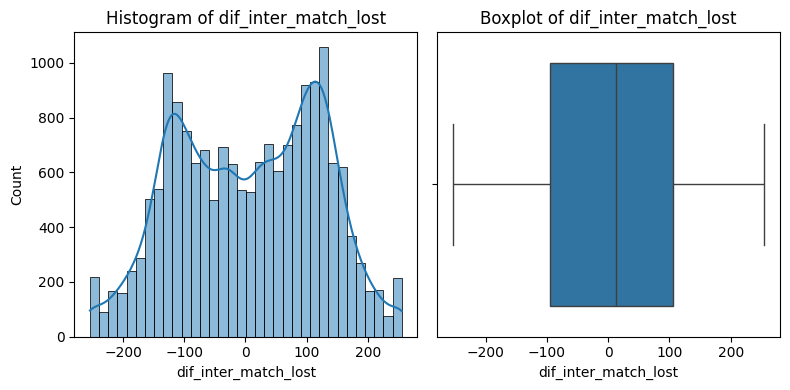

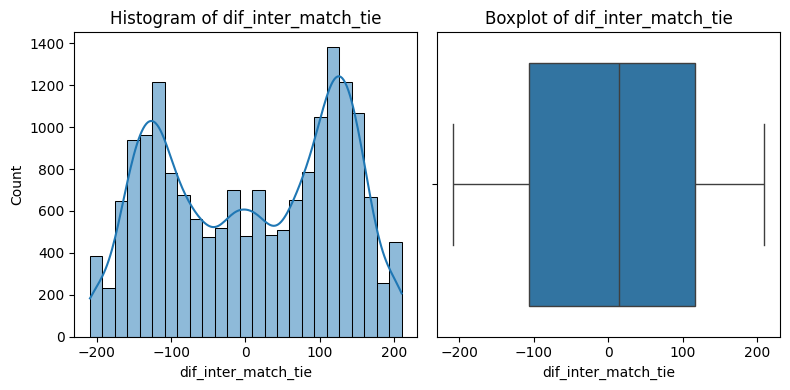

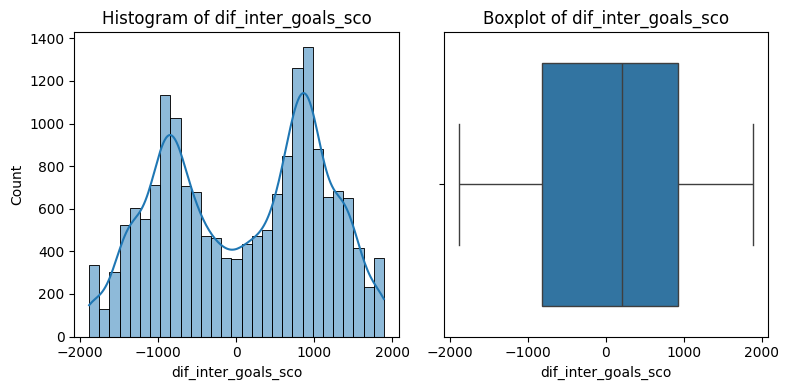

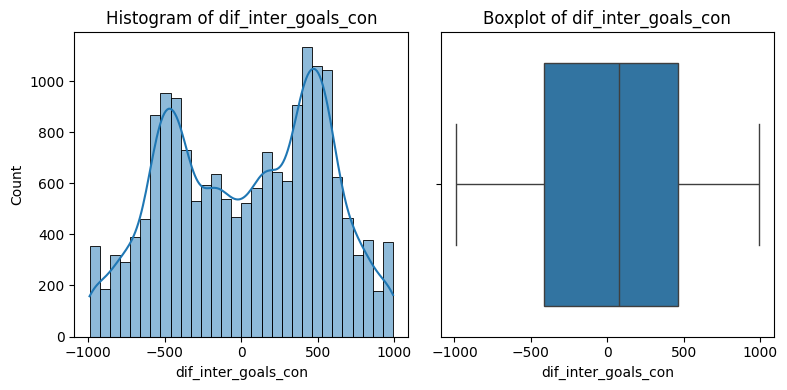

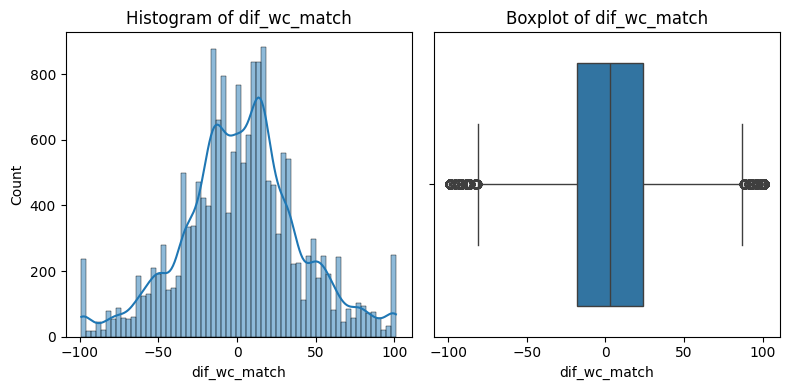

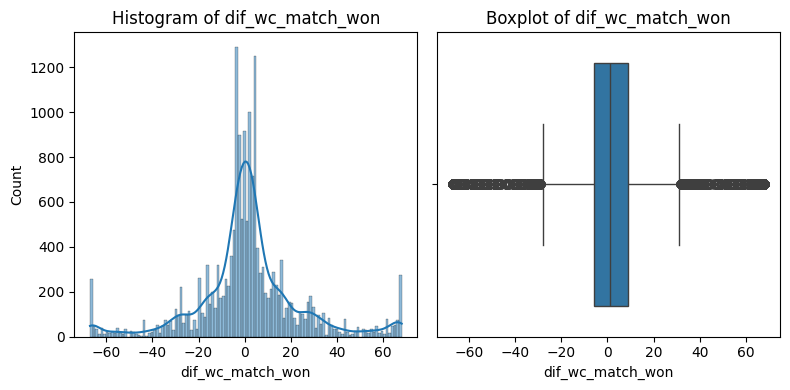

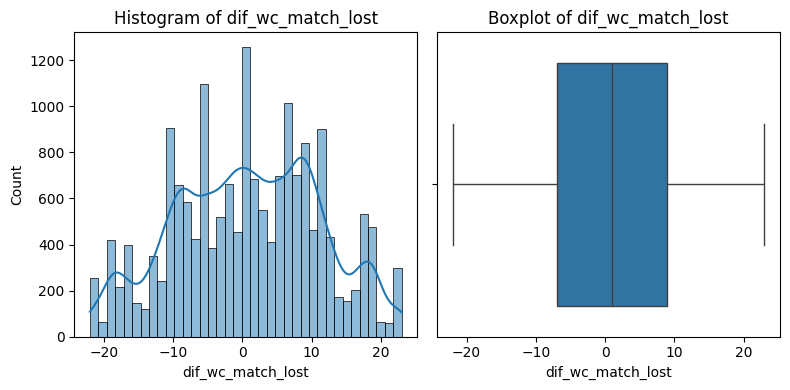

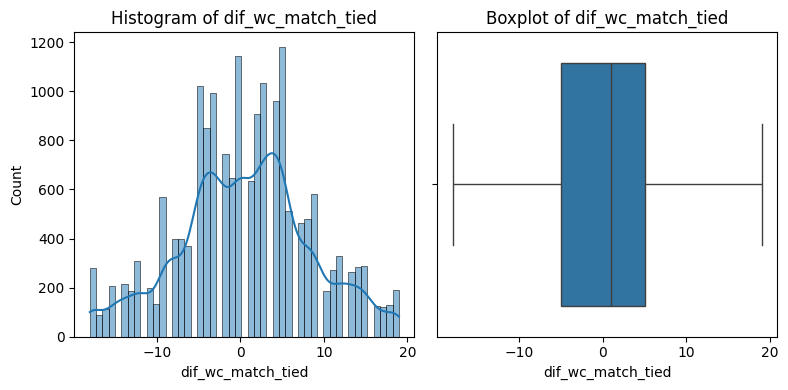

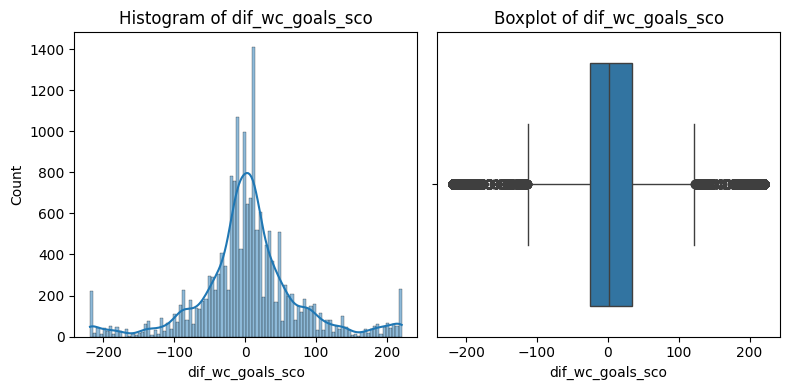

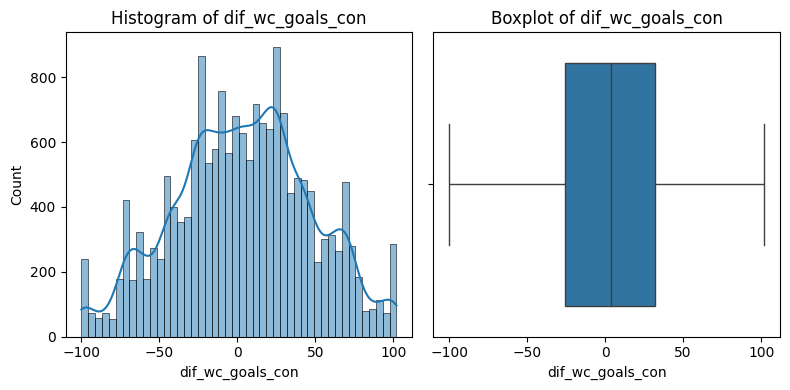

In [ ]:
for feature in numerical_features:
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(matches_clean[feature], kde=True)
    plt.title(f'Histogram of {feature}')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=matches_clean[feature])
    plt.title(f'Boxplot of {feature}')

    plt.tight_layout()
    plt.show()

In [ ]:
skewness = matches_clean[numerical_features].skew().sort_values(ascending=False)
print("Skewness of numerical features:")
print(skewness)

Skewness of numerical features:
dif_wc_match_won        0.109127
dif_wc_goals_sco        0.088320
dif_wc_match           -0.004879
dif_wc_match_tied      -0.038685
dif_wc_goals_con       -0.048138
dif_wc_match_lost      -0.063798
dif_inter_match_lost   -0.089035
dif_inter_goals_con    -0.111459
dif_inter_match_tie    -0.112324
dif_inter_match_won    -0.114186
dif_inter_goals_sco    -0.118882
dif_inter_match        -0.125599
dtype: float64


All skewness magnitudes are under ≈ 0.13, which is considered very low. That means each distribution is close to symmetric—there are no heavy tails or severe outliers.

# Data Preparation

In [ ]:
matches_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17812 entries, 0 to 17811
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            17812 non-null  int64  
 1   wcm                   17812 non-null  int64  
 2   dif_inter_match       17812 non-null  float64
 3   dif_inter_match_won   17812 non-null  float64
 4   dif_inter_match_lost  17812 non-null  float64
 5   dif_inter_match_tie   17812 non-null  float64
 6   dif_inter_goals_sco   17812 non-null  float64
 7   dif_inter_goals_con   17812 non-null  float64
 8   dif_wc_match          17812 non-null  float64
 9   dif_wc_match_won      17812 non-null  float64
 10  dif_wc_match_lost     17812 non-null  float64
 11  dif_wc_match_tied     17812 non-null  float64
 12  dif_wc_goals_sco      17812 non-null  float64
 13  dif_wc_goals_con      17812 non-null  float64
 14  status                17812 non-null  int64  
dtypes: float64(12), int

we keep only qualifier matches `(wcm = 0)`, so that World-Cup games remain unseen

In [ ]:
matches_clean = matches_clean.drop('Unnamed: 0', axis=1)

qualifier_matches = matches_clean.query('wcm == 0').reset_index(drop=True)
qualifier_matches = qualifier_matches.drop('wcm',axis=1)

wc_matches = matches_clean.query('wcm == 1').reset_index(drop=True)
wc_matches = wc_matches.drop('wcm',axis=1)

In [ ]:
print(qualifier_matches.info())
print(wc_matches.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16912 entries, 0 to 16911
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   dif_inter_match       16912 non-null  float64
 1   dif_inter_match_won   16912 non-null  float64
 2   dif_inter_match_lost  16912 non-null  float64
 3   dif_inter_match_tie   16912 non-null  float64
 4   dif_inter_goals_sco   16912 non-null  float64
 5   dif_inter_goals_con   16912 non-null  float64
 6   dif_wc_match          16912 non-null  float64
 7   dif_wc_match_won      16912 non-null  float64
 8   dif_wc_match_lost     16912 non-null  float64
 9   dif_wc_match_tied     16912 non-null  float64
 10  dif_wc_goals_sco      16912 non-null  float64
 11  dif_wc_goals_con      16912 non-null  float64
 12  status                16912 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 1.7 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 89

Define X(features) and Y(target) and Removes the outcome column (status). We use X and Y for training process.<br> Also, Encode the label (status: 1→0, 2→1, 3→2)<br>
why we do this? PyTorch expects class labels to be 0-based integer indices:

In [ ]:
X_qualifier = qualifier_matches.drop(columns=['status'])
Y_qualifier = (qualifier_matches['status'] - 1)
unique_statuses = Y_qualifier.unique()
print("Unique status values:", unique_statuses)

print(X_qualifier.shape)
print(Y_qualifier.shape)

Unique status values: [0 2 1]
(16912, 12)
(16912,)


In [ ]:
X_test = wc_matches.drop(columns=['status'])
Y_test = (wc_matches['status'] - 1)

print(X_test.shape)
print(Y_test.shape)

(900, 12)
(900,)


# Model Definition

We implemented a multilayer perceptron class, ResidualMLP, a compact two-layer MLP with a direct shortcut around it. By learning F(x) such that the block output is F(x)+x, the network can more easily model both subtle corrective terms and the identity function when needed, leading to faster, more stable training and often better final accuracy.<br>

BatchNorm1d after each linear layer is used to standardizes each hidden dimension to zero mean and unit variance (per batch), which stabilizes learning. Also it reduces internal covariate shift so higher learning rates become feasible.<br>

ReLU activations introduce non-linearity so the block isn’t just a linear identity. Also, Keeps gradients from saturating (unlike sigmoids), while the final ReLU after the addition ensures outputs remain non-negative.




In [ ]:
class ResidualMLP(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim)
        )
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.block(x)
        return self.relu(out + x)

Here, the Net class defines the main neural network model architecture used to predict match outcomes. <br>
It begins by projecting the 12 input features into a 128-dimensional space using a fully connected layer followed by a ReLU activation. This is followed by our residualMLP block. The final output head reduces the features through additional layers, ending with three output neurons representing the possible match outcomes: home win, draw, or away win. All layers use Kaiming initialization to support efficient learning. Overall, the architecture balances simplicity with depth, making it well-suited for learning from structured tabular data.

In [ ]:
class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU()
        )
        self.residual = ResidualMLP(128)
        self.output_layer = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )
        self._init_weights()
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
    def forward(self, x):
        x = self.input_layer(x)
        x = self.residual(x)
        return self.output_layer(x)

A loss like focal loss can penalize “easy” majority predictions and push the net to attend to rarer classes. It makes the training Focuse on the harder minority classes (Draw).

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(reduction='none')
    def forward(self, logits, targets):
        logp = -self.ce(logits, targets)
        p    = logp.exp()
        loss = -((1 - p) ** self.gamma) * logp
        return loss.mean()

#  Model Training

In [ ]:
print("CUDA available:", torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Training on:", device)

CUDA available: False
Training on: cpu


In [ ]:
def train_one_epoch(model, loader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        preds = logits.argmax(dim=1)
        total_loss += loss.item() * xb.size(0)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
    return total_loss / total, correct / total * 100

In [ ]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            preds = logits.argmax(dim=1)
            total_loss += loss.item() * xb.size(0)
            correct += (preds == yb).sum().item()
            total += xb.size(0)
    return total_loss / total, correct / total * 100

In [ ]:
def make_loader(X, Y, balanced=False, batch_size=64):
    tX = torch.tensor(X, dtype=torch.float32)
    tY = torch.tensor(Y, dtype=torch.long)
    if balanced:
        weights = 1.0 / np.bincount(Y)
        sample_weights = weights[Y].tolist()
        sampler = WeightedRandomSampler(sample_weights, len(Y), replacement=True)
        return DataLoader(TensorDataset(tX, tY), batch_size=batch_size, sampler=sampler)
    return DataLoader(TensorDataset(tX, tY), batch_size=batch_size, shuffle=False)

In [ ]:
Xq = X_qualifier.to_numpy()
Xtest = X_test.to_numpy()
Yq = Y_qualifier.to_numpy()

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
histories = {}
ensemble_preds = np.zeros((len(X_test), 3), dtype=np.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
for fold, (train_idx, val_idx) in enumerate(kf.split(X_qualifier, Y_qualifier), 1):
    scaler = StandardScaler().fit(Xq[train_idx])
    X_tr = scaler.transform(Xq[train_idx])
    X_val = scaler.transform(Xq[val_idx])
    X_te = scaler.transform(Xtest)

    train_loader = make_loader(X_tr, Yq[train_idx], balanced=True)
    val_loader = make_loader(X_val, Yq[val_idx])

    model = Net(input_dim=X_tr.shape[1]).to(device)
    criterion = FocalLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-5)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-2,
        steps_per_epoch=len(train_loader),
        epochs=50,
        pct_start=0.2,
        div_factor=10,
        final_div_factor=100
    )

    histories[fold] = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_loss = float('inf')

    for epoch in range(1, 51):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, scheduler, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        histories[fold]['train_loss'].append(tr_loss)
        histories[fold]['train_acc'].append(tr_acc)
        histories[fold]['val_loss'].append(val_loss)
        histories[fold]['val_acc'].append(val_acc)

        print(f"Fold {fold} | Epoch {epoch:02d} | Train: {tr_loss:.4f}/{tr_acc:.2f}% | "
              f"Val: {val_loss:.4f}/{val_acc:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"best_fold{fold}.pt")


Fold 1 | Epoch 01 | Train: 0.4932/46.17% | Val: 0.5025/50.61%
Fold 1 | Epoch 02 | Train: 0.4603/46.27% | Val: 0.4642/50.25%
Fold 1 | Epoch 03 | Train: 0.4467/47.34% | Val: 0.4544/47.00%
Fold 1 | Epoch 04 | Train: 0.4399/48.81% | Val: 0.4502/50.58%
Fold 1 | Epoch 05 | Train: 0.4346/49.40% | Val: 0.4370/48.89%
Fold 1 | Epoch 06 | Train: 0.4343/49.24% | Val: 0.4495/46.70%
Fold 1 | Epoch 07 | Train: 0.4348/49.47% | Val: 0.4457/49.16%
Fold 1 | Epoch 08 | Train: 0.4382/48.73% | Val: 0.4370/51.37%
Fold 1 | Epoch 09 | Train: 0.4358/49.36% | Val: 0.4372/54.51%
Fold 1 | Epoch 10 | Train: 0.4338/49.29% | Val: 0.4303/54.03%
Fold 1 | Epoch 11 | Train: 0.4373/48.90% | Val: 0.4468/50.25%
Fold 1 | Epoch 12 | Train: 0.4342/49.26% | Val: 0.4481/47.30%
Fold 1 | Epoch 13 | Train: 0.4344/50.14% | Val: 0.4491/48.86%
Fold 1 | Epoch 14 | Train: 0.4335/50.24% | Val: 0.4414/52.26%
Fold 1 | Epoch 15 | Train: 0.4328/49.57% | Val: 0.4549/46.47%
Fold 1 | Epoch 16 | Train: 0.4306/49.61% | Val: 0.4337/53.12%
Fold 1 |

# Evaluating Model

 Reload the best model checkpoint:<br>
 The evaluation block re-creates the MatchOutcomeMLP, restores the best checkpoint from disk, and toggles the network to evaluation mode. This guarantees that inference uses the same learned parameters and disables training-time layers such as Dropout, yielding stable and reproducible predictions.

In [ ]:
scalers = []
scalers.append(scaler)
ensemble_preds = np.zeros((len(X_test), 3), dtype=np.float32)
for fold, sc in enumerate(scalers, 1):
    model = Net(input_dim=X_qualifier.shape[1]).to(device)
    model.load_state_dict(torch.load(f"best_fold{fold}.pt"))
    model.eval()

    X_test_scaled = sc.transform(X_test)
    tX_test = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
    with torch.no_grad():
        logits = model(tX_test)
        ensemble_preds += logits.softmax(dim=1).cpu().numpy()

ensemble_preds /= kf.n_splits

Y_pred = ensemble_preds.argmax(axis=1)
print("Test Accuracy:", accuracy_score(Y_test, Y_pred) * 100)
print(classification_report(Y_test, Y_pred, target_names=['Home','Draw','Away']))
cm = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:\n", cm)

Test Accuracy: 50.11111111111111
              precision    recall  f1-score   support

        Home       0.66      0.62      0.64       503
        Draw       0.26      0.27      0.26       199
        Away       0.38      0.43      0.40       198

    accuracy                           0.50       900
   macro avg       0.43      0.44      0.44       900
weighted avg       0.51      0.50      0.51       900

Confusion Matrix:
 [[313  98  92]
 [101  53  45]
 [ 60  53  85]]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


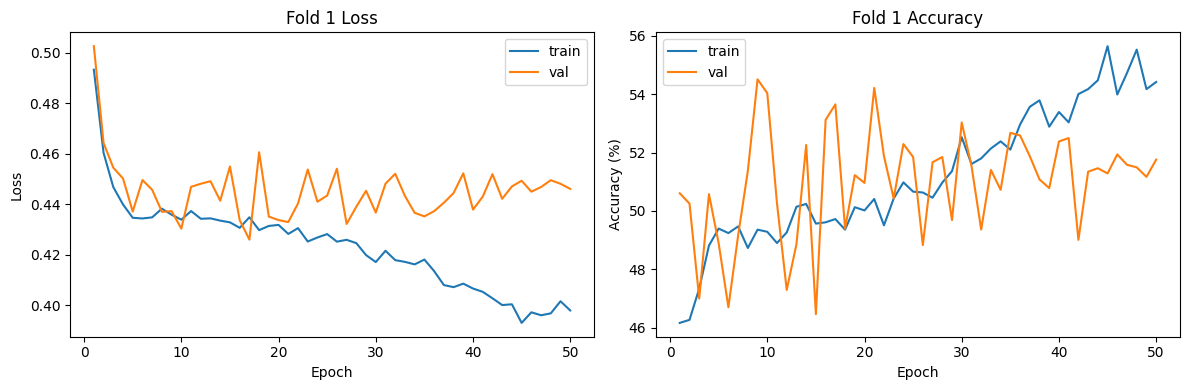

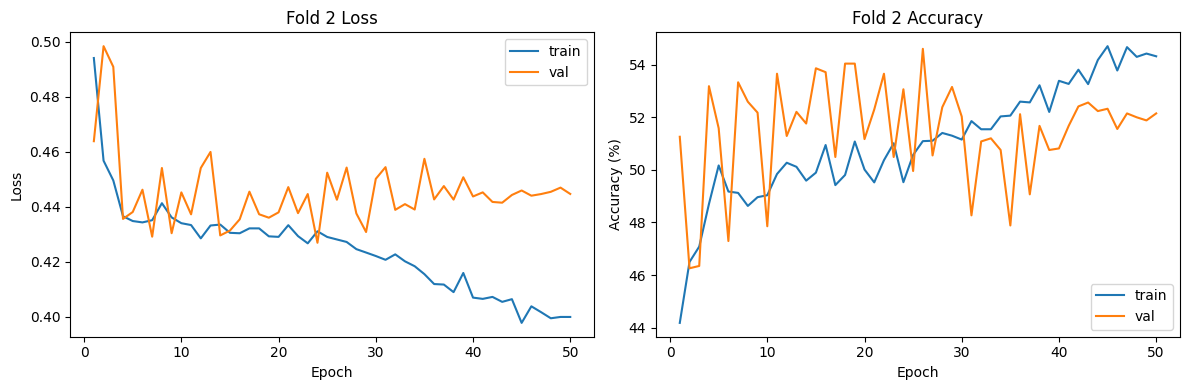

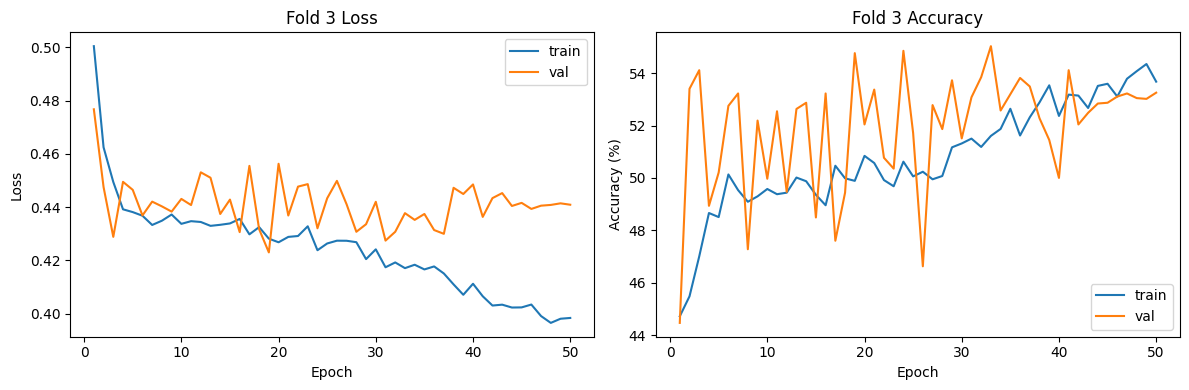

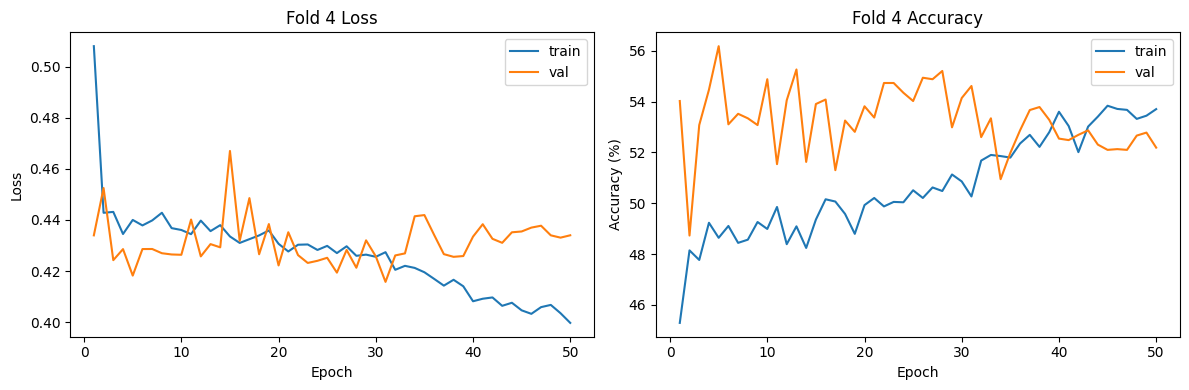

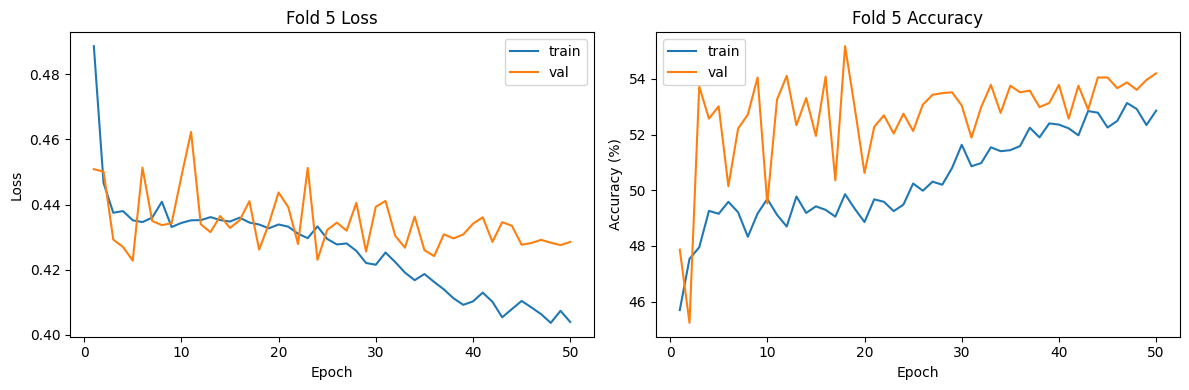

In [ ]:
for fold, h in histories.items():
    epochs = range(1, len(h['train_loss']) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(epochs, h['train_loss'], label='train')
    ax1.plot(epochs, h['val_loss'], label='val')
    ax1.set_title(f'Fold {fold} Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax2.plot(epochs, h['train_acc'], label='train')
    ax2.plot(epochs, h['val_acc'], label='val')
    ax2.set_title(f'Fold {fold} Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    plt.tight_layout()
    plt.show()

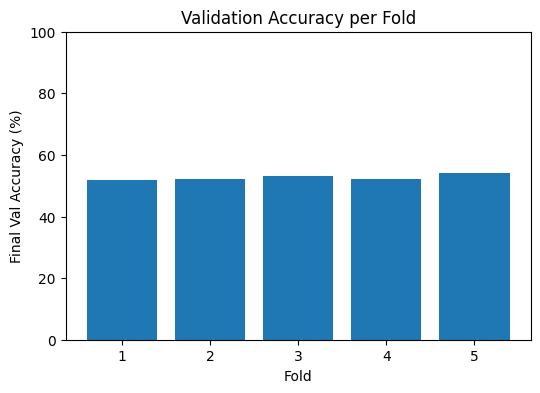

In [ ]:
folds = sorted(histories.keys())
final_val_acc = [histories[f]['val_acc'][-1] for f in folds]
plt.figure(figsize=(6, 4))
plt.bar(folds, final_val_acc)
plt.ylim(0, 100)
plt.xlabel('Fold')
plt.ylabel('Final Val Accuracy (%)')
plt.title('Validation Accuracy per Fold')
plt.show()

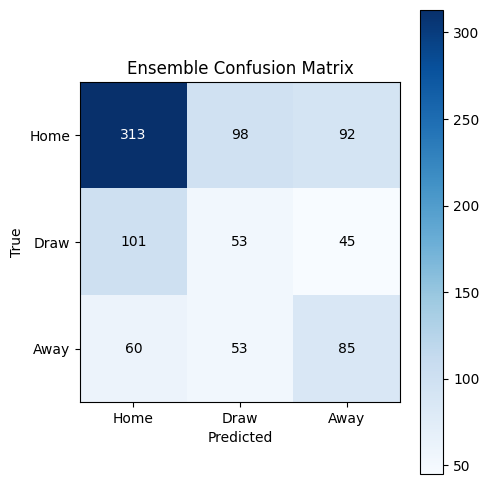

In [ ]:
labels = ['Home', 'Draw', 'Away']
plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Ensemble Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(labels)), labels)
plt.yticks(np.arange(len(labels)), labels)
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, cm[i, j], ha='center', va='center',
                 color='white' if cm[i, j] > cm.max() / 2 else 'black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

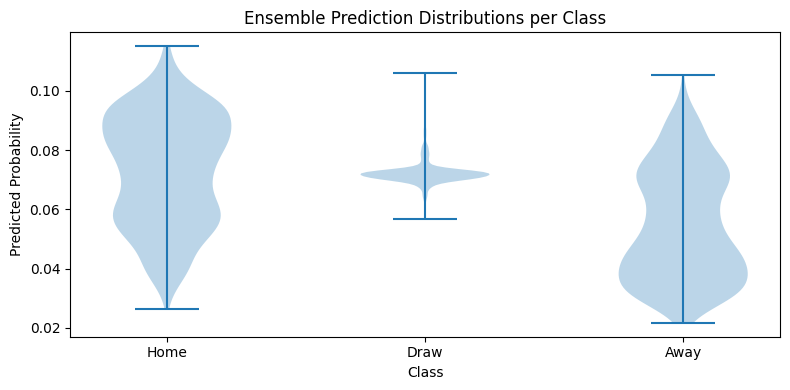

In [ ]:
data = [ensemble_preds[:, i] for i in range(len(labels))]

plt.figure(figsize=(8, 4))
plt.violinplot(data, showmeans=False)
plt.xticks(np.arange(1, len(labels)+1), labels)
plt.xlabel('Class')
plt.ylabel('Predicted Probability')
plt.title('Ensemble Prediction Distributions per Class')
plt.tight_layout()
plt.show()

# FIFA World CUP

In [ ]:
groups = {
    'A': ['Qatar', 'Ecuador', 'Senegal', 'Netherlands'],
    'B': ['England', 'Iran', 'USA', 'Wales'],
    'C': ['Argentina', 'Saudi Arabia', 'Mexico', 'Poland'],
    'D': ['France', 'Australia', 'Denmark', 'Tunisia'],
    'E': ['Spain', 'Costa Rica', 'Germany', 'Japan'],
    'F': ['Belgium', 'Canada', 'Morocco', 'Croatia'],
    'G': ['Brazil', 'Serbia', 'Switzerland', 'Cameroon'],
    'H': ['Portugal', 'Ghana', 'Uruguay', 'South Korea']
}

We implemented the `agg_stats` function to extract key performance statistics for a given team from the match dataset. This includes the number of matches played, won, lost, and tied, as well as goals scored and conceded. These statistics are used to compute the difference in team strength between two opponents, which serves as input features for our prediction model. The function supports customizable prefixes to distinguish between international match stats and World Cup-specific stats.

In [ ]:
def agg_stats(df, team, prefix):
    played = len(df[(df.home_team==team)|(df.away_team==team)])
    won = len(df[((df.home_team==team)&(df.status==1))|((df.away_team==team)&(df.status==3))])
    lost = len(df[((df.home_team==team)&(df.status==3))|((df.away_team==team)&(df.status==1))])
    tied = len(df[df.status==2])
    gs = (df[df.home_team==team].home_goals.sum() + df[df.away_team==team].away_goals.sum())
    gc = (df[df.home_team==team].away_goals.sum() + df[df.away_team==team].home_goals.sum())
    return {
        f'{prefix}_match': played,
        f'{prefix}_match_won': won,
        f'{prefix}_match_lost': lost,
        f'{prefix}_match_tie': tied,
        f'{prefix}_goals_sco': gs,
        f'{prefix}_goals_con': gc
    }

We implemented the `build_match_features` function to generate the input feature vector for a given match between two teams. It calculates the difference in performance statistics (matches played, won, lost, tied, goals scored and conceded) between the home and away teams, both for all international matches and World Cup matches. These differences are combined into a single feature row, matching the format used during model training, and returned as a DataFrame ready for prediction.

In [ ]:
def build_match_features(home, away, history_df, feature_cols):

    inter_home = agg_stats(history_df, home, 'inter')
    inter_away = agg_stats(history_df, away, 'inter')
    dif_inter = {f'dif_{k}': inter_home[k] - inter_away[k] for k in inter_home}

    wc_df = history_df.query('wcm==1')
    wc_home = agg_stats(wc_df, home, 'wc')
    wc_away = agg_stats(wc_df, away, 'wc')
    dif_wc = {f'dif_{k}': wc_home[k] - wc_away[k] for k in wc_home}

    all_feats = {**dif_inter, **dif_wc}
    row = pd.DataFrame([{c: all_feats.get(c, 0) for c in feature_cols}])
    return row

We implemented the `simulate_match` function to predict the outcome of a match between two teams using our trained neural network model. The function first constructs the match features using` build_match_features`, applies the same scaling used during training, and feeds the result into the model. It then computes the softmax probabilities for each possible outcome (home win, draw, away win) and returns both the predicted class and the associated probabilities.

In [ ]:
def simulate_match(home, away):
    feat_df = build_match_features(home, away, matches, numerical_features)
    X = scaler.transform(feat_df.values)
    tX = torch.tensor(X, dtype=torch.float32).to(device)
    with torch.no_grad():
        logits = model(tX)
        probs = torch.softmax(logits, dim=1).cpu().numpy().ravel()
    pred = probs.argmax() + 1
    return pred, probs

In [ ]:
best_fold = min(histories.items(),key=lambda item: min(item[1]['val_loss']))[0]
print("Best fold is:", best_fold)

Best fold is: 4


In [ ]:
model = Net(len(numerical_features)).to(device)
model.load_state_dict(torch.load("best_fold4.pt"))
model.eval()
scaler = scalers[0]

We initialize a dictionary group_pts to store points for each team in every group.<br>
For each group, we simulate all six possible matches between the four teams (round-robin format).

In [ ]:
group_pts = {g: defaultdict(int) for g in groups}

for g, teams in groups.items():
    for i in range(4):
        for j in range(i+1,4):
            h, a = teams[i], teams[j]
            result, _ = simulate_match(h, a)
            if result==1:      group_pts[g][h] += 3
            elif result==2:    group_pts[g][h] += 1; group_pts[g][a] += 1
            else:
                 group_pts[g][a] += 3

After all group matches are simulated, we sort the teams in each group by descending points.
If points are equal, alphabetical order is used as a tiebreaker.
The top two teams from each group qualify for the knockout stage and are stored in group_qualifiers.

In [ ]:
group_qualifiers = {}
for g, pts in group_pts.items():
    ranked = sorted(pts.items(), key=lambda x:(-x[1], x[0]))
    group_qualifiers[g] = [team for team,_ in ranked[:2]]
    print(f"Group {g} → 1st: {group_qualifiers[g][0]}, 2nd: {group_qualifiers[g][1]}")


Group A → 1st: Ecuador, 2nd: Netherlands
Group B → 1st: England, 2nd: Wales
Group C → 1st: Argentina, 2nd: Poland
Group D → 1st: France, 2nd: Denmark
Group E → 1st: Germany, 2nd: Spain
Group F → 1st: Belgium, 2nd: Croatia
Group G → 1st: Brazil, 2nd: Serbia
Group H → 1st: Portugal, 2nd: Uruguay


This list defines the Round of 16 matchups based on the FIFA World Cup 2022 bracket rules: group winners face runners-up from paired groups.

In [ ]:
r16 = [
    (group_qualifiers['A'][0], group_qualifiers['B'][1]),
    (group_qualifiers['C'][0], group_qualifiers['D'][1]),
    (group_qualifiers['E'][0], group_qualifiers['F'][1]),
    (group_qualifiers['G'][0], group_qualifiers['H'][1]),
    (group_qualifiers['B'][0], group_qualifiers['A'][1]),
    (group_qualifiers['D'][0], group_qualifiers['C'][1]),
    (group_qualifiers['F'][0], group_qualifiers['E'][1]),
    (group_qualifiers['H'][0], group_qualifiers['G'][1]),
]

This function simulates a knockout round.
If the model predicts a win, that team advances.
If it predicts a draw, the team with the higher win probability (softmax output) is chosen as the winner (as a tiebreaker).
It returns the list of winners to be used in the next stage.

In [ ]:
def play_round(matches):
    winners = []
    for home, away in matches:
        res, probs = simulate_match(home, away)
        if res==1:        winner = home
        elif res==3:      winner = away
        else:             # draw → pick side with higher win‐prob
            winner = home if probs[0]>probs[2] else away
        print(f"{home} vs {away} → {winner}")
        winners.append(winner)
    return winners

We simulate the tournament progression:

Quarterfinals: 8 teams play, 4 advance

Semifinals: 4 teams play, 2 advance

finalists: Final match pairing

champion: Winner of the final (index [0] since the list has one match)

In [ ]:
qf = play_round(r16)
sf = play_round([(qf[0],qf[1]), (qf[2],qf[3]), (qf[4],qf[5]), (qf[6],qf[7])])
finalists = play_round([(sf[0],sf[1]), (sf[2],sf[3])])
champion = play_round([tuple(finalists)])[0]

print(f"\n Predicted Champion: {champion}")

Ecuador vs Wales → Ecuador
Argentina vs Denmark → Argentina
Germany vs Croatia → Germany
Brazil vs Uruguay → Brazil
England vs Netherlands → England
France vs Poland → France
Belgium vs Spain → Spain
Portugal vs Serbia → Portugal
Ecuador vs Argentina → Argentina
Germany vs Brazil → Brazil
England vs France → France
Spain vs Portugal → Spain
Argentina vs Brazil → Argentina
France vs Spain → France
Argentina vs France → Argentina

 Predicted Champion: Argentina
